# Notebook 30: Optimal Sampling

In [1]:
from imf import EmbeddedCluster, Star, IGIMF
from sampling import OptimalSampling, RandomSampling
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
SFR = 0.01 #Msun yr-1
FeH = 0
delta_t = 1e7 #yr

In [3]:
def sample_histogram(sample, N=1):
    limits = [0.08]
    csis = []

    j = 0
    for i, m in enumerate(sample):
        j += 1
        if j == N:
            try:
                limit = m/2 + sample[i+1]/2 
            except IndexError:
                limit = (3/2)*m - limits[-1]/2
            limits.append(limit)
            j = 0

    for i, m_i in enumerate(limits[:-1]):
        m_iplus1 = limits[i+1]
        delta_m = m_iplus1 - m_i
        csi = N/delta_m
        csis.append(csi)
    
    CSI_X = np.sort(np.append(limits, limits))

    CSI_Y = np.array([2*[csi] for csi in csis]).flatten()
    CSI_Y = np.insert(CSI_Y, 0, 0)
    CSI_Y = np.append(CSI_Y, 0)

    CSI = np.array([CSI_X, CSI_Y]).T
    return CSI

#### Random Sampling

In [4]:
N_sample = 1e5
sample_mmin = 0.08
sample_mmax = 150

In [5]:
star_masses = np.logspace(np.log10(0.08), np.log10(150), 100)[1:]

igimf = IGIMF(SFR, FeH)
igimf.get_clusters()

In [6]:
random_sampler = RandomSampling(igimf)

In [7]:
random_sampler.compute_imf()

In [8]:
random_sample = random_sampler.get_sample(0.08, 150, 1e6)

Text(0.87, 0.7, 'Each histogram column \n contains 50 stars.')

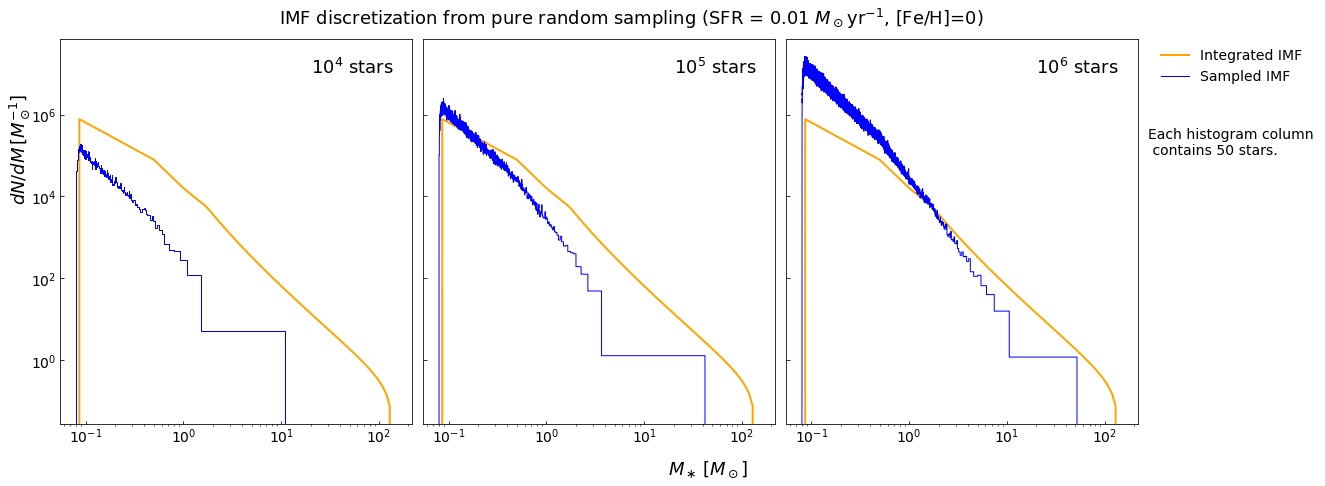

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey='row', tight_layout=True)
ns = [1e4, 1e5, 1e6]

for ax, n in zip(axes, ns):
    random_sample = random_sampler.get_sample(0.08, 150, n)
    random_sampling_imf = sample_histogram(random_sample, 50)
    
    ax.plot(random_sampler.discretization_masses, random_sampler.discrete_imf, '-', c='orange', lw=2, label='Integrated IMF')
    ax.plot(random_sampling_imf[:,0], random_sampling_imf[:,1], 'b-', lw=1, label='Sampled IMF')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.text(20, 1e7, r'$10^%.i$ stars' % np.log10(n), fontsize=18)
    ax.tick_params(axis='both', direction='in', labelsize=14)

axes[2].legend(loc=(1.05, 0.87), fontsize=14, frameon=False)
    
fig.text(0.2, 1, f'IMF discretization from pure random sampling (SFR = {SFR} $M_\odot$yr$^{{-1}}$, [Fe/H]=0)', fontsize=18)
fig.text(-0.01, 0.6, '$dN/dM\, [M_\odot^{-1}]$', rotation=90, fontsize=18)
fig.text(0.5, -0.04, r'$M_\ast\,[M_\odot]$', fontsize=18)
fig.text(0.87, 0.7, 'Each histogram column \n contains 50 stars.', fontsize=14)

Text(0.87, 0.7, 'Each histogram column \n contains 50 stars.')

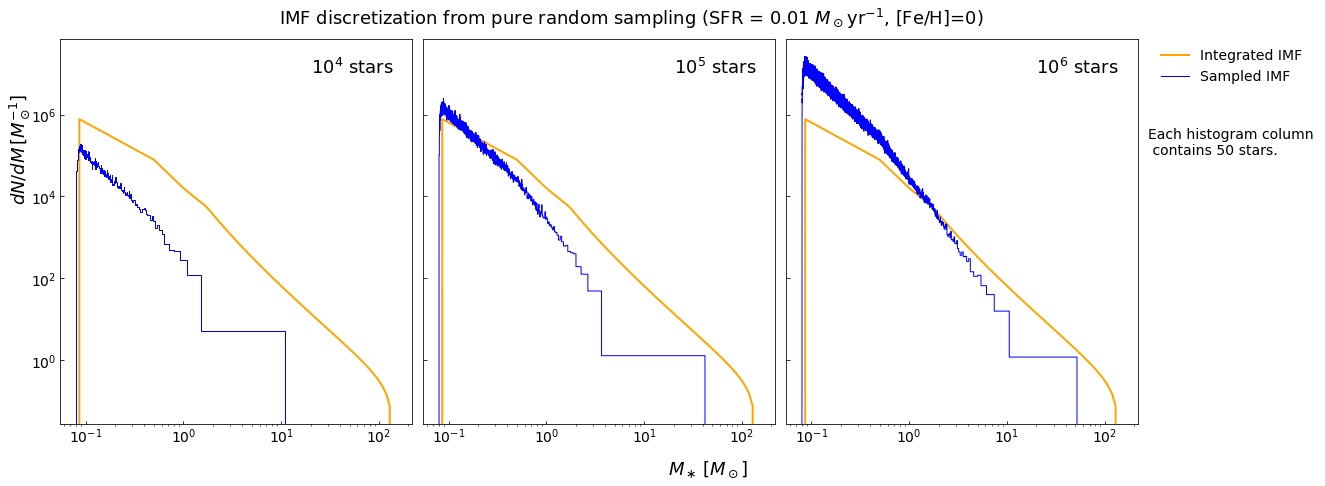

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey='row', tight_layout=True)
ns = [1e4, 1e5, 1e6]

for ax, n in zip(axes, ns):
    random_sample = random_sampler.get_sample(0.08, 150, n)
    random_sampling_imf = sample_histogram(random_sample, 50)
    
    ax.plot(random_sampler.discretization_masses, random_sampler.discrete_imf, '-', c='orange', lw=2, label='Integrated IMF')
    ax.plot(random_sampling_imf[:,0], random_sampling_imf[:,1], 'b-', lw=1, label='Sampled IMF')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.text(20, 1e7, r'$10^%.i$ stars' % np.log10(n), fontsize=18)
    ax.tick_params(axis='both', direction='in', labelsize=14)

axes[2].legend(loc=(1.05, 0.87), fontsize=14, frameon=False)
    
fig.text(0.2, 1, f'IMF discretization from pure random sampling (SFR = {SFR} $M_\odot$yr$^{{-1}}$, [Fe/H]=0)', fontsize=18)
fig.text(-0.01, 0.6, '$dN/dM\, [M_\odot^{-1}]$', rotation=90, fontsize=18)
fig.text(0.5, -0.04, r'$M_\ast\,[M_\odot]$', fontsize=18)
fig.text(0.87, 0.7, 'Each histogram column \n contains 50 stars.', fontsize=14)

#### Sampling the IGIMF

Let's generate the IGIMF for an example galaxy with a certain FeH and SFR.

Now we generate embedded cluster populations of the galaxy through optimal sampling of the ECMF.

In [11]:
clusters = EmbeddedCluster(SFR, delta_t)
clusters.get_mmax_k()
print(f'Mmax = {clusters.m_max}')
#clusters._get_k()
cluster_sampler = OptimalSampling(clusters)
cluster_sampler.set_limits()
cluster_sample = cluster_sampler.get_sample()
cluster_sampler.set_n_tot()
cluster_sampler.set_m_tot()

Mmax = 5203.088494807744


In [12]:
cluster_masses = np.logspace(np.log10(5), np.log10(clusters.m_max), 100)
ECMF = np.array([clusters.imf(m) for m in cluster_masses])

In [13]:
cluster_limits = cluster_sampler._upper_limits

In [14]:
csis = []

for i, m_i in enumerate(cluster_limits[:-1]):
    m_iplus1 = cluster_limits[i+1]
    delta_m = m_i - m_iplus1
    csi = 1/delta_m
    csis.append(csi)

In [15]:
CSI = np.empty((0,2), np.float64)

for center, lower_limit, upper_limit, csi in zip(cluster_sample, cluster_limits[:-1], cluster_limits[1:], csis):
    CSI = np.append(CSI, np.array([[lower_limit, csi]]), axis=0)
    CSI = np.append(CSI, np.array([[center, csi]]), axis=0)
    CSI = np.append(CSI, np.array([[upper_limit, csi]]), axis=0)   

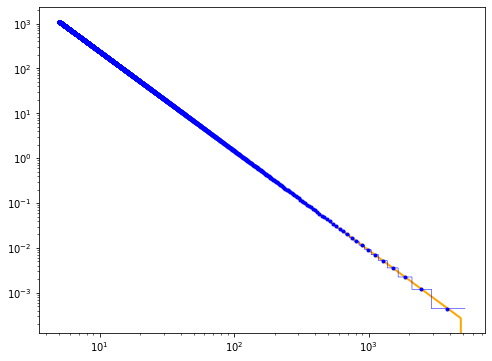

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cluster_masses, ECMF, '-', c='orange', lw=2)
ax.plot(CSI[:,0], CSI[:,1], 'b-', lw=0.5)
ax.plot(cluster_sample, csis, 'b.')

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(4, 1e4)

Now, for _each_ sampled cluster we must sample a population of stars from the stellar IMF.

In [20]:
star_samples = []

fraction = 0
total = len(cluster_sample)
for counter, cluster in enumerate(cluster_sample):
    fraction += 1/total
    if fraction >= 0.1:
        print(f'Sampling for Mecl = {cluster}, {counter} of {len(cluster_sample)} ({100*counter/total:.2f}%)')
        fraction = 0
    stars = Star(cluster, FeH)   
    stars.get_mmax_k()
    stars._set_k2_k3()
    star_sampler = OptimalSampling(stars)
    star_sampler.set_n_tot()
    star_sampler.set_m_tot()
    star_sampler.set_limits()
    star_sample = star_sampler.get_sample()
    star_samples.append(star_sample)
star_sample = np.sort(np.concatenate(star_samples))

Sampling for Mecl = 33.386951001922014, 453 of 4537 (9.98%)
Sampling for Mecl = 18.853814591554833, 907 of 4537 (19.99%)
Sampling for Mecl = 13.495069896746616, 1361 of 4537 (30.00%)
Sampling for Mecl = 10.644450370702387, 1815 of 4537 (40.00%)
Sampling for Mecl = 8.854911168215462, 2269 of 4537 (50.01%)
Sampling for Mecl = 7.618444321249274, 2723 of 4537 (60.02%)
Sampling for Mecl = 6.708710732638674, 3177 of 4537 (70.02%)
Sampling for Mecl = 6.008941425986947, 3631 of 4537 (80.03%)
Sampling for Mecl = 5.452534208831542, 4085 of 4537 (90.04%)


In [23]:
star_masses = np.logspace(np.log10(0.08), np.log10(150), 50)[1:]

igimf = IGIMF(SFR, FeH)
igimf.get_clusters()
igimfs = np.array([igimf.imf(m)[0] for m in star_masses])

In [24]:
simple_star_limits = star_masses

In [25]:
simple_scsis = []

for i, m_i in enumerate(simple_star_limits[:-1]):
    m_iplus1 = simple_star_limits[i+1]
    delta_m = np.abs(m_iplus1 - m_i)
    n = len([m for m in star_sample if (m>=m_i and m<m_iplus1)])
    scsi = n/delta_m
    simple_scsis.append(scsi)

In [26]:
simple_sCSI_X = np.sort(np.append(simple_star_limits, simple_star_limits[1:-1]))
simple_sCSI_Y = np.array([2*[csi] for csi in simple_scsis]).flatten()
simple_sCSI = np.array([simple_sCSI_X, simple_sCSI_Y]).T

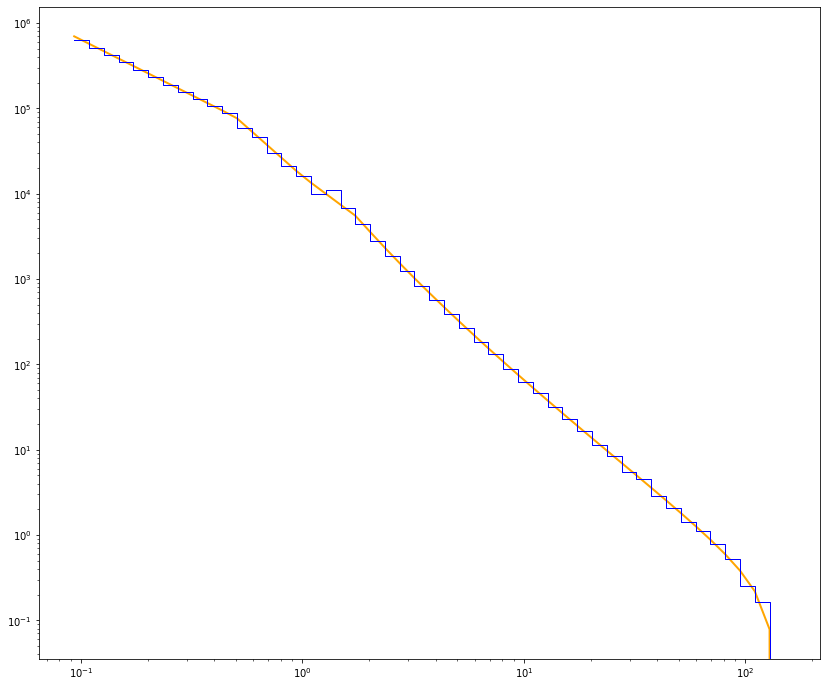

In [27]:
fig, ax = plt.subplots(figsize=(14,12))

ax.plot(star_masses, igimfs, '-', c='orange', lw=2)
ax.plot(simple_sCSI[:,0], simple_sCSI[:,1], 'b-', lw=1)
#ax.plot(star_sample, scsis, 'b.')

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(4, 1e4)
#ax.vlines(0.08, 1, 1e8)

In [33]:
histN = 50
sCSI = sample_histogram(star_sample, histN)

Text(250, 300000.0, 'Each histogram column \n contains 50 stars.')

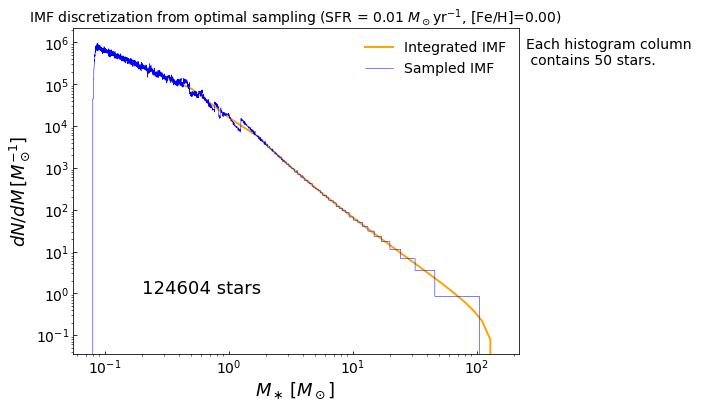

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(star_masses, igimfs, '-', c='orange', lw=2, label='Integrated IMF')
ax.plot(sCSI[:,0], sCSI[:,1], 'b-', lw=0.5, label='Sampled IMF')

ax.set_xlabel(r'$M_\ast\,[M_\odot]$', fontsize=18)
ax.set_ylabel(r'$dN/dM\,[M_\odot^{-1}]$', fontsize=18)
ax.set_title(f'IMF discretization from optimal sampling (SFR = {SFR} $M_\odot$yr$^{{-1}}$, [Fe/H]={FeH:.2f})', fontsize=14)
ax.legend(loc='upper right', fontsize=14, frameon=False)

ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', direction='in', labelsize=14)

ax.text(0.2, 1, f'{star_sample.shape[0]} stars', fontsize=18)
ax.text(250, 3e5, f'Each histogram column \n contains {histN} stars.', fontsize=14)

In [30]:
sCSI_fine = sample_histogram(star_sample)

(0.01, 100000000.0)

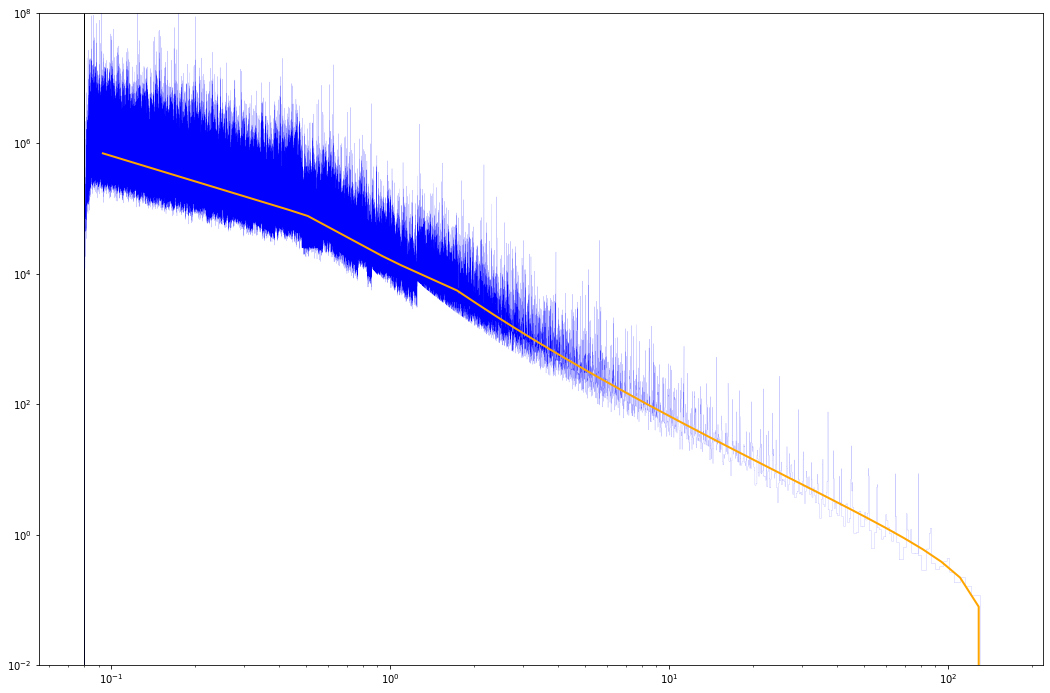

In [31]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.vlines(0.08, 1e-2, 1e8, 'k', alpha=1, lw=1)
#ax.plot(sCSI_fine[:,0], sCSI_fine[:,1], 'b.'', ms=0.5)
ax.plot(sCSI_fine[:,0], sCSI_fine[:,1], 'b-', lw=0.1)
ax.plot(star_masses, igimfs, '-', c='orange', lw=2)
#ax.plot(star_sample, scsis, 'b.')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_xlim(4, 1e4)
ax.set_ylim(1e-2, 1e8)

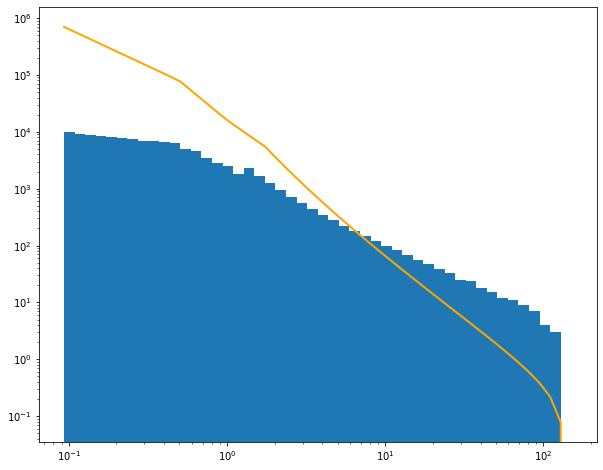

In [32]:
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(star_sample, bins=star_masses)
ax.plot(star_masses, igimfs, '-', c='orange', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')